### Imports

In [1]:
import itertools
from tqdm.auto import tqdm, trange
import random
import os
import sys
from io import StringIO
from IPython import get_ipython


import torch
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset, load_from_disk

from pyvene import(
    CausalModel, IntervenableModel, IntervenableConfig,
    RepresentationConfig, RotatedSpaceIntervention,
    BoundlessRotatedSpaceIntervention,
)

from transformers import (
    AutoTokenizer, get_scheduler,
    AutoModelForCausalLM, GPT2LMHeadModel
)

from accelerate import Accelerator
from accelerate.utils import set_seed

import transformers
transformers.logging.set_verbosity_error()

In [2]:
"""
# ipython_exit.py
Allows exit() to work if script is invoked with IPython without
raising NameError Exception. Keeps kernel alive.

Use: import variable 'exit' in target script with
     'from ipython_exit import exit'    
"""

class IpyExit(SystemExit):
    """Exit Exception for IPython.

    Exception temporarily redirects stderr to buffer.
    """
    def __init__(self):
        # print("exiting")  # optionally print some message to stdout, too
        # ... or do other stuff before exit
        sys.stderr = StringIO()

    def __del__(self):
        sys.stderr.close()
        sys.stderr = sys.__stderr__  # restore from backup


def ipy_exit():
    raise IpyExit


if get_ipython():    # ...run with IPython
    exit = ipy_exit  # rebind to custom exit
else:
    exit = exit      # just make exit importable

### Hyperparameters

In [3]:
seed = 42
mixed_precision = 'no'  # choose from no, fp16, bf16 or fp8
# needed for dataset generation in case of counterfactual dataset
batch_size = 8

set_seed(seed)

### Special variables

In [4]:
# Longest command is 9 words : https://arxiv.org/pdf/1711.00350
max_command_len = 9
# dummy tokens for formatting
EMPTY = "<empty>" # "EMPTY"
PORT = "<port>"
ACT = "<act>"

### Causal Model

In [5]:
# command type maps
actions = {
    "walk": "I_WALK",
    "run": "I_RUN",
    "jump": "I_JUMP",
    "look": "I_LOOK",
    "turn": EMPTY,
    EMPTY: EMPTY,
    }

turns = {
    "around": "yyyy",
    "opposite": "yy",
    EMPTY: EMPTY
}

directions = {
    "right": "I_TURN_RIGHT",
    "left": "I_TURN_LEFT",
    EMPTY: EMPTY
}

nums = {
    "twice": "xx",
    "thrice": "xxx",
    EMPTY: EMPTY
}

conjs = ["and", "after", EMPTY]

# command structure
command_structure = {
    0: actions,
    1: turns,
    2: directions,
    3: nums,
    4: conjs,
    5: actions,
    6: turns,
    7: directions,
    8: nums,
}


### VARIABLES ###

# longest command is 9 words : https://arxiv.org/pdf/1711.00350
# This ordering (left to right) is important for downstream code!
leaves = [
    "act1", "trn1", "dir1", "num1",
    "conj",
    "act2", "trn2", "dir2", "num2"
]
non_leaves = [
    "trn1_res", "trn1_dir1", "act1_trn1_dir1", 
    "num1_res", "act1_trn1_dir1_num1",
    "trn2_res", "trn2_dir2", "act2_trn2_dir2", 
    "num2_res", "act2_trn2_dir2_num2",
    "conj_left", "conj_right",
]
variables = leaves + non_leaves

### FUNCTIONS ###

def resolve_turn(turn):
    return turns[turn]

# need to represent ACT differently?
def turn_function(turn, dir):
    dir = directions[dir]
    if dir == EMPTY:
        return EMPTY
    elif turn == EMPTY:
        dec_act = dir + ' '+ACT+' '
    elif turn == "yyyy":
        dec_act = (dir + ' '+ACT+' ')*len(turn) 
    else:
        dec_act = (dir + ' ')*len(turn) + ACT
    return dec_act.strip()

def action_function(act, trn_dir):
    if trn_dir == EMPTY:
        return actions[act]
    return (trn_dir.replace(ACT, actions[act])).strip()

def resolve_num(num):
    return nums[num]

def num_function(act_trn_dir, num):
    if num == EMPTY:
        return act_trn_dir
    dec = (act_trn_dir + ' ') * len(num)
    return dec.strip()

def conjugation_left(act1_trn1_dir1_num1, conj):
    if conj == EMPTY:
        return act1_trn1_dir1_num1
    elif conj == "and":
        return act1_trn1_dir1_num1 + PORT
    else:
        return PORT + act1_trn1_dir1_num1
    

def conjugation_right(conj_left, act2_trn2_dir2_num2):
    if act2_trn2_dir2_num2 == EMPTY:
        f_str = conj_left
    # after
    elif conj_left.startswith(PORT):
        f_str = act2_trn2_dir2_num2 + conj_left
    # and
    else:
        f_str = conj_left + act2_trn2_dir2_num2
    f_str = f_str.replace(PORT, ' ')
    f_str = f_str.replace((' '+EMPTY+' '), ' ')
    f_str = f_str.replace(EMPTY, '')
    return f_str.strip()

functions = {

    # leaves
    "act1": lambda x: x,
    "act2": lambda x: x,
    "trn1": lambda x: x,
    "trn2": lambda x: x,
    "dir1": lambda x: x,
    "dir2": lambda x: x,
    "num1": lambda x: x,
    "num2": lambda x: x,
    "conj": lambda x: x,

    # resolving turn
    "trn1_res": resolve_turn,
    "trn2_res": resolve_turn,

    # combining turn and direction
    "trn1_dir1": turn_function,
    "trn2_dir2": turn_function,

    # combining turn_direction and action
    "act1_trn1_dir1": action_function,
    "act2_trn2_dir2": action_function,

    # resolving num
    "num1_res": resolve_num,
    "num2_res": resolve_num,

    # combining action_turn_direction and num
    "act1_trn1_dir1_num1": num_function,
    "act2_trn2_dir2_num2": num_function,

    # conj with left segment
    "conj_left": conjugation_left,

    # conj with right segment
    "conj_right": conjugation_right,
}


### VALUES ###

values = dict()

# leaves
values["act1"] = list(actions.keys())
values["act2"] = list(actions.keys())
values["trn1"] = list(turns.keys())
values["trn2"] = list(turns.keys())
values["dir1"] = list(directions.keys())
values["dir2"] = list(directions.keys())
values["num1"] = list(nums.keys())
values["num2"] = list(nums.keys())
values["conj"] = conjs


# resolve turn
values["trn1_res"] = [resolve_turn(t) for t in values["trn1"]]
values["trn2_res"] = values["trn1_res"].copy()

# turn+dir
all_trn_dir = list(itertools.product(values["trn1_res"], values["dir1"]))
values["trn1_dir1"] = list(set([turn_function(tup[0], tup[1]) for tup in all_trn_dir]))
values["trn2_dir2"] = values["trn1_dir1"].copy()

# act+turn_dir
all_act_trn_dir = list(itertools.product(values["act1"], values["trn1_dir1"]))
values["act1_trn1_dir1"] = list(set([action_function(tup[0], tup[1]) for tup in all_act_trn_dir]))
values["act2_trn2_dir2"] = values["act1_trn1_dir1"].copy()

# resolve num
values["num1_res"] = [resolve_num(n) for n in values["num1"]]
values["num2_res"] = values["num1_res"].copy()

# act_turn_dir+num
all_act_trn_dir_num = list(itertools.product(values["act1_trn1_dir1"], values["num1_res"]))
values["act1_trn1_dir1_num1"] = list(set([num_function(tup[0], tup[1]) for tup in all_act_trn_dir_num]))
values["act2_trn2_dir2_num2"] = values["act1_trn1_dir1_num1"].copy()

# conj_left
all_conj_left = list(itertools.product(values["act1_trn1_dir1_num1"], conjs))
values["conj_left"] = list(set([conjugation_left(tup[0], tup[1]) for tup in all_conj_left]))

# conj_right
all_conj_right = list(itertools.product(values["conj_left"], values["act2_trn2_dir2_num2"]))
values["conj_right"] = list(set([conjugation_right(tup[0], tup[1]) for tup in all_conj_right]))


### PARENTS ###

parents = {v:[] for v in variables}
# left subtree
parents["trn1_res"] = ["trn1"]
parents["trn1_dir1"] = ["trn1_res", "dir1"]
parents["act1_trn1_dir1"] = ["act1", "trn1_dir1"]
parents["num1_res"] = ["num1"]
parents["act1_trn1_dir1_num1"] = ["act1_trn1_dir1", "num1_res"]
# right subtree
parents["trn2_res"] = ["trn2"]
parents["trn2_dir2"] = ["trn2_res", "dir2"]
parents["act2_trn2_dir2"] = ["act2", "trn2_dir2"]
parents["num2_res"] = ["num2"]
parents["act2_trn2_dir2_num2"] = ["act2_trn2_dir2", "num2_res"]
# merge
parents["conj_left"] = ["act1_trn1_dir1_num1", "conj"]
parents["conj_right"] = ["conj_left", "act2_trn2_dir2_num2"]


### POSITIONS ###

# a dictionary with nodes as keys and positions as values
pos = {

    # left subtree
    "act1": (1, 0),
    "trn1": (2, 0),
    "dir1": (1.9, 0.05),
    "num1": (4, 0),
    "conj": (4.11, 0.1),
    "act1": (0.2, 0),
    "trn1": (1, 0.1),
    "trn1_res": (1.33, 0.4),
    "dir1": (2, 0.3),
    "num1": (2.8, 0),
    "num1_res": (3, 0.2),
    "trn1_dir1": (1.4, 0.96),
    "act1_trn1_dir1": (0.2, 1.5),
    "act1_trn1_dir1_num1": (2.5, 1.8),

    # right subtree
    "act2": (5, 0),
    "trn2": (6, 0),
    "dir2": (5.9, 0.05),
    "num2": (9, 0),
    "act2": (5.2, 0),
    "trn2": (6, 0.1),
    "trn2_res": (6, 0.4),
    "dir2": (7, 0.3),
    "num2": (9.8, 0),
    "num2_res": (9, 0.2),
    "trn2_dir2": (6.4, 1),
    "act2_trn2_dir2": (5.2, 1.5),
    "act2_trn2_dir2_num2": (7.5, 1.8),

    # merge
    "conj_left": (3.5, 2.2),
    "conj_right": (4.5, 3.2),
}

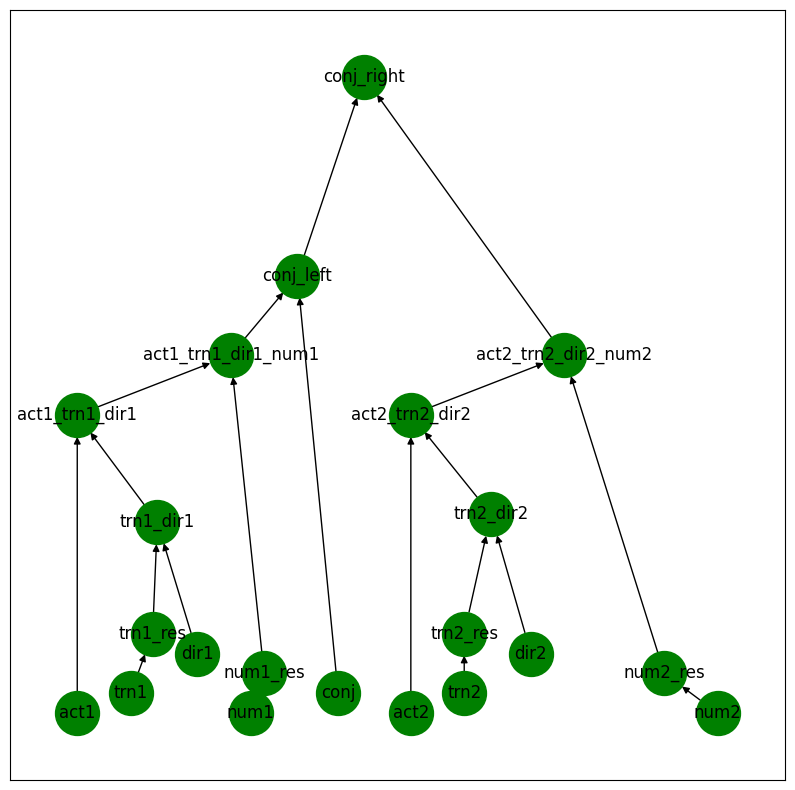

In [6]:
causal_model = CausalModel(variables, values, parents, functions, pos=pos)
causal_model.print_structure()

### Intervention on conj_left

#### Load trained GPT2 (on original SCAN dataset)

In [7]:
#checkpoint = '/home/drdo/Caricatures/models/scan_distilgpt2/checkpoint-40000'
checkpoint = '/users/ujan/caricatures/models/scan/distilgpt2_40k'
max_gen_length = 512

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = GPT2LMHeadModel.from_pretrained(checkpoint)
model.generation_config.max_length = max_gen_length

In [8]:
#generation_mode = GenerationMode.GREEDY_SEARCH

context = 'run <empty> right twice after walk <empty> right twice'
inputs = tokenizer(context+tokenizer.sep_token, return_tensors="pt")

output = model.generate(**inputs)[0]
output = tokenizer.decode(output, skip_special_tokens=False).replace(context+tokenizer.sep_token, '')
output = output.replace(tokenizer.eos_token, '')
print(output)

I_TURN_RIGHT I_WALK I_TURN_RIGHT I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN


#### Build 'perfect' counterfactual dataset

In [9]:
def validate_leaf_config_counterfactual(input):
    # condition1: conj cannot be empty
    if input['conj'] == EMPTY:
        return True
    # condition2 : actions cannot be empty
    if input['act1'] == EMPTY or input['act2'] == EMPTY:
        return True
    # condition3 : if direction is empty, turn has to be empty
    if input['dir1'] == EMPTY and input['trn1'] != EMPTY:
        return True
    if input['dir2'] == EMPTY and input['trn2'] != EMPTY:
        return True
    

def validate_by_model(x, causal_model, model, tokenizer, device):
    command = ' '.join(list(x.values()))
    label = causal_model.run_forward(x)['conj_right']
    inputs = tokenizer(command+tokenizer.sep_token, return_tensors="pt").to(device)
    output = model.generate(**inputs)[0].to("cpu")
    output = tokenizer.decode(output, skip_special_tokens=False).replace(command+tokenizer.sep_token, '')
    output = output.replace(tokenizer.eos_token, '')
    if output == label:
        return True
    else:
        return False


def generate_counterfactual_dataset_conj_left(
        causal_model,
        model,
        tokenizer, 
        device,
        size,
        intervention_id,
        batch_size,
        sampler=None,
        intervention_sampler=None,
        filter=None,
    ):
        # all non leaf non output variables
        maxlength = len(
            [
                var
                for var in causal_model.variables
                if var not in causal_model.inputs and var not in causal_model.outputs
            ]
        )
        if sampler is None:
            sampler = causal_model.sample_input
        if intervention_sampler is None:
            intervention_sampler = causal_model.sample_intervention

        examples = []
        bar = tqdm(range(size))
        while len(examples) < size:
            # dict with intermediate (non leaf) variable(s) and its (their) (intervened) value(s)
            # Ex: sample_intervention:
            # randomly select intermediate variables to intervene, then randomly select
            # possible values from their range
            intervention = intervention_sampler()
            if filter is None or filter(intervention):
                # same intervention for each batch
                for _ in range(batch_size):
                    example = dict()

                    # sample base input
                    invalid_input = True
                    # check if base is solved by given model
                    model_solvable = False
                    while invalid_input and not model_solvable:
                        base = sampler()
                        invalid_input = validate_leaf_config_counterfactual(base)
                        if not invalid_input:
                            model_solvable = validate_by_model(base, causal_model, model, tokenizer, device)

                    sources = []
                    # intervened_var : source input tensor
                    source_dic = {}
                    for var in causal_model.variables:
                        if var not in intervention:
                            continue
                        # sample input to match sampled intervention value for each intervened variable
                        # to get source input
                        # Ex: sample_input_tree_balanced:
                        # This will generate balanced samples since an output is first chosen at random
                        # and one of the possible input settings is derived recursively, top down.
                        # If output_var and out_var_value is given, this will generate an input setting
                        # to match the output variable.
                        # output_var can be an intermediate variable
                        invalid_input = True
                        # check if source is solved by given model
                        model_solvable = False
                        while invalid_input and not model_solvable:
                            source = sampler(output_var=var, output_var_value=intervention[var])
                            invalid_input = validate_leaf_config_counterfactual(source)
                            if not invalid_input:
                                model_solvable = validate_by_model(source, causal_model, model, tokenizer, device)

                        sources.append(source)
                        source_dic[var] = source

                    # pad sources to maxlength
                    for _ in range(maxlength - len(sources)):
                        sources.append({})

                    example['labels'] = causal_model.run_interchange(base, source_dic)
                    example['base_labels'] = causal_model.run_forward(base)
                    example['input_ids'] = base
                    example['source_input_ids'] = sources
                    example['intervention_id'] = [intervention_id(intervention)]

                    examples.append(example)

                    bar.update(1)
                    
        return examples
    

# you should be able to identify intervened variables from the id function
def conj_left_intervention_id(intervention):
    return 0


# need to make sure that intervention returns value (from all possible values),
# where conj is present
def conj_left_intervention_sampler():
    intervention = {}
    var = 'conj_left'
    port_condition = True
    while(port_condition):
        int_val = random.choice(causal_model.values[var])
        if PORT in int_val:
            intervention[var] = int_val
            port_condition = False
    return intervention

In [10]:
#data_size = 16000
#data_size = 256
data_size = 16

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
model.to(device)

counter_examples = generate_counterfactual_dataset_conj_left(
    causal_model,
    model,
    tokenizer,
    device,
    data_size,
    conj_left_intervention_id,
    batch_size,
    sampler=causal_model.sample_input_tree_balanced,
    intervention_sampler=conj_left_intervention_sampler,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/16 [00:00<?, ?it/s]

This dataset has the following components:

* `input_ids`: base inputs
* `source_input_ids`: source, values will be empty dicts for non intervened vars
* `base_labels`: output labels with base for all non leaves
* `labels`: output labels with base and intervention from source for all non leaves
* `intervention_id`: same id since intervening on single variable

In [11]:
sample_id = 8

print(counter_examples[sample_id]["input_ids"])
# padded to maxlength
# maxlength = number of non leaf and non root nodes
print(counter_examples[sample_id]["source_input_ids"])
print(counter_examples[sample_id]["base_labels"])
print(counter_examples[sample_id]["labels"])
# you should be able to identify intervened variables from the id function
print(counter_examples[sample_id]["intervention_id"])

{'act1': 'walk', 'trn1': '<empty>', 'dir1': '<empty>', 'num1': '<empty>', 'conj': 'and', 'act2': 'run', 'trn2': '<empty>', 'dir2': 'right', 'num2': 'twice'}
[{'act1': 'look', 'trn1': '<empty>', 'dir1': 'right', 'num1': '<empty>', 'conj': 'after', 'act2': 'look', 'dir2': 'right', 'num2': 'thrice', 'trn2': '<empty>'}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
defaultdict(None, {'act1': 'walk', 'act2': 'run', 'conj': 'and', 'dir1': '<empty>', 'dir2': 'right', 'num1': '<empty>', 'num2': 'twice', 'trn1': '<empty>', 'trn2': '<empty>', 'num1_res': '<empty>', 'num2_res': 'xx', 'trn1_res': '<empty>', 'trn2_res': '<empty>', 'trn1_dir1': '<empty>', 'trn2_dir2': 'I_TURN_RIGHT <act>', 'act1_trn1_dir1': 'I_WALK', 'act2_trn2_dir2': 'I_TURN_RIGHT I_RUN', 'act1_trn1_dir1_num1': 'I_WALK', 'act2_trn2_dir2_num2': 'I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN', 'conj_left': 'I_WALK<port>', 'conj_right': 'I_WALK I_TURN_RIGHT I_RUN I_TURN_RIGHT I_RUN'})
defaultdict(None, {'act1': 'walk', 'act2': 'run', 'conj': 'and',

In [12]:
print(counter_examples[0].keys())

print(counter_examples[sample_id]["base_labels"]['conj_right'].split()[0])
print(counter_examples[sample_id]["labels"]['conj_right'].split()[0])
print(counter_examples[sample_id]["input_ids"]['conj'])
print(counter_examples[sample_id]["source_input_ids"][0]['conj'])

dict_keys(['labels', 'base_labels', 'input_ids', 'source_input_ids', 'intervention_id'])
I_WALK
I_TURN_RIGHT
and
after


In [13]:
#TODO : is counterfactual dataset balanced?

#### Process counterfactual dataset

Perform intervention at the beginning. GPT2 always uses causal masking : https://github.com/huggingface/transformers/issues/3069#issuecomment-593163603

* `base_inputs`= `base_command` + `source_actions given by causal model after intervention`
* `source_inputs` = `source_command` + `source_actions given by causal model after intervention`
* `base_labels` = `base_inputs`
* `labels` = `source_inputs`

If intervention is at layer = l, model is attending from intervened actions to base inputs in layers < l. Maybe always do interventions at all layers or all subsequent layers after l?

In [11]:
# convert examples to Huggingface dataset
counter_dataset = Dataset.from_list(counter_examples)

max_source_length = 300
max_gen_length = 512
# process dataset for gpt input
def process_dataset(x):

    # first convert to strings
    # then tokenize to tensors

    # labels
    #base_labels = x['base_labels']['conj_right']
    labels = x['labels']['conj_right']

    # base
    command_list = []
    leaf2comm = x['input_ids']
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    base = ' '.join(command_list)
    
    # tokenize as single sequence separated by special token
    base_tokenized = tokenizer(
        base+tokenizer.sep_token,
        # source_actions given by causal model after intervention
        labels+tokenizer.eos_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['input_ids'] = base_tokenized['input_ids']
    x['attention_mask'] = base_tokenized['attention_mask']
    # labels same as inputs. labels shifted right in the model forward by default
    #x['base_labels'] = x['input_ids'].copy()
    # set label padding to -100 
    #x['base_labels'] = [(l if l != tokenizer.pad_token_id else -100) for l in x['base_labels']]

    # source
    command_list = []
    # only one intervention variable
    leaf2comm = x['source_input_ids'][0]
    # make sure leaves are odered correctly
    for leaf in leaves:
        command_list.append(leaf2comm[leaf])
    source = ' '.join(command_list)
    # tokenize as single sequence separated by special token
    source_tokenized = tokenizer(
        source+tokenizer.sep_token,
        # source_actions given by causal model after intervention
        labels+tokenizer.eos_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['source_input_ids'] = source_tokenized['input_ids']
    x['source_attention_mask'] = source_tokenized['attention_mask']
    # labels same as inputs. labels shifted right in the model forward by default
    x['labels'] = x['source_input_ids'].copy()
    # set label padding to -100 
    x['labels'] = [(l if l != tokenizer.pad_token_id else -100) for l in x['labels']]

    # commands only for generation
    # base
    base_command = tokenizer(
        base+tokenizer.sep_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['base_command_ids'] = base_command['input_ids']
    x['base_command_attention_mask'] = base_command['attention_mask']
    # source
    source_command = tokenizer(
        source+tokenizer.sep_token,
        padding='max_length',
        max_length=max_source_length
    )
    x['source_command_ids'] = source_command['input_ids']
    x['source_command_attention_mask'] = source_command['attention_mask']

    # intervention_id
    x['intervention_id'] = torch.tensor(x['intervention_id'])

    return x


counter_dataset_processed = counter_dataset.map(
    process_dataset,
    batched=False,
    num_proc=1,
    remove_columns=['base_labels']
)
counter_dataset_processed.set_format(type="torch")

print(counter_dataset_processed.column_names)

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

['labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask', 'base_command_ids', 'base_command_attention_mask', 'source_command_ids', 'source_command_attention_mask']


In [16]:
counter_dataset_processed.save_to_disk('/home/drdo/Caricatures/data/processed/scan_counterfactual_dataset_16k')

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

#### Load processed counterfactual dataset

In [65]:
counter_dataset_processed = load_from_disk('/home/drdo/Caricatures/data/processed/scan_counterfactual_dataset_16k')
counter_dataset_processed

Dataset({
    features: ['labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask', 'base_command_ids', 'base_command_attention_mask', 'source_command_ids', 'source_command_attention_mask'],
    num_rows: 16000
})

#### Boundless DAS

In [28]:
ignore_index = -100
epochs = 10
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(counter_dataset_processed) * epochs
lr = 0.001
t_total = int(len(counter_dataset_processed) * epochs)

In [29]:
layer = 0

config = IntervenableConfig(
    model_type=type(model),
    representations=[RepresentationConfig(layer, "block_output")],
    intervention_types=BoundlessRotatedSpaceIntervention,
)

In [30]:
intervenable = IntervenableModel(config, model, use_fast=True)
intervenable.model.generation_config.max_length = max_gen_length

intervenable.set_device(device)
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


In [31]:
optimizer_params = []
# single DAS intervention
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v[0].rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=lr)


# outputs -> b x max_source_len x vocab
# labels -> max_source_len x vocab
# causal mask on loss?
def compute_loss(outputs, labels):
    ce_loss = CrossEntropyLoss(ignore_index=ignore_index)  # , reduce=False)
    loss = 0
    for b in range(batch_size):
        loss += ce_loss(outputs[b], labels[b])
    loss = loss/batch_size
    return loss


def compute_metrics(counterfactual_outputs, labels):
    accuracy = 0
    for b in range(batch_size):
        pred = (tokenizer.decode(
            counterfactual_outputs[b]
        ).split(tokenizer.sep_token)[-1]).replace(tokenizer.eos_token, '')
        labels[b][labels[b] == -100] = tokenizer.pad_token_id
        gt = tokenizer.decode(labels[b]).split(
            tokenizer.sep_token)[-1].split(tokenizer.eos_token)[0]
        if pred == gt:
            accuracy += 1
    return {"accuracy": accuracy/batch_size}


def collate_function(batch):
    """base_label_max_len = max([batch[i]['base_labels'].shape[0] for i in range(batch_size)])
    label_max_len = max([batch[i]['labels'].shape[0] for i in range(batch_size)])

    for b in range(batch_size):
        base_label = batch[b]['base_labels']
        label = batch[b]['labels']
        base_label = F.pad(base_label, (0, base_label_max_len-base_label.shape[0]), value=ignore_index)
        label = F.pad(label, (0, label_max_len-label.shape[0]), value=ignore_index)
        batch[b]['base_labels'] = base_label
        batch[b]['labels'] = label"""

    # turn batch from list of dicts to dict of lists
    # https://stackoverflow.com/questions/5558418/list-of-dicts-to-from-dict-of-lists
    batch = {k: torch.stack([dic[k] for dic in batch]) for k in batch[0]}
    return batch


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

##### Train

In [32]:
token_posn = 0

In [34]:
# intervenable.model.train()  # train enables drop-off but no grads
# eval() makes forward pass deterministic -> pseudorandom in dropout with train()?
# https://github.com/huggingface/transformers/issues/2627#issuecomment-578043926
# TODO: check loss
intervenable.model.eval()
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

total_step = 0
for epoch in train_iterator:
    epoch_acc = 0
    epoch_loss = 0
    epoch_iterator = tqdm(
        DataLoader(
            counter_dataset_processed,
            collate_fn=collate_function,
            sampler=batched_random_sampler(counter_dataset_processed),
            batch_size=batch_size,
            drop_last=True
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True
    )
    # 'labels', 'input_ids', 'source_input_ids', 'intervention_id', 'attention_mask', 'source_attention_mask'
    for batch in epoch_iterator:

        # run with base commands and source->base actions
        base_input_ids = batch["input_ids"].to(device)
        base_attention_mask = batch["attention_mask"].to(device)
        source_input_ids = batch["source_input_ids"].to(device)
        source_attention_mask = batch["source_attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # base
        inputs = {
            "input_ids": base_input_ids,
            "attention_mask": base_attention_mask
        }
        # list of source inputs
        sources = [
            {
                "input_ids": source_input_ids,
                "attention_mask": source_attention_mask
            }
        ]
        # simulating generation
        # counterfactual_outputs -> b x max_source_len x vocab
        _, counterfactual_outputs = intervenable(
            inputs,
            sources,
            # unit_locations -> tuple(source, base)
            # unit_locations. from intervenable_base.py:

            # unit_locations_sources = unit_locations["sources->base"][0]
            # unit_locations_base = unit_locations["sources->base"][1]

            # unit_locations_sources[key] goes into intervention_getter
            # ex:
            # unit_locations["sources->base"][1][0] = [[0]] * batch_size
            # [[0], [0], [0], [0], [0], [0], [0], [0]] -> first seq posn from each x in batch

            # unit_locations_base[key] goes into intervention_setter
            {
                "sources->base": (
                    # token posn in each x in batch
                    [[[token_posn]] * batch_size],   # source
                    [[[token_posn]] * batch_size]    # base
                )
            },
            # output_original_output=True,
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs.logits, labels)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()

        # generation and eval
        # intervention with only commands, then let model generate
        # TODO: does generation after intervention work as expected?
        base_command_ids = batch['base_command_ids'].to(device)
        base_command_attention_mask = batch['base_command_attention_mask'].to(
            device)
        source_command_ids = batch['source_command_ids'].to(device)
        source_command_attention_mask = batch['source_command_attention_mask'].to(
            device)
        # base
        inputs = {
            "input_ids": base_command_ids,
            "attention_mask": base_command_attention_mask
        }
        # list of source inputs
        sources = [
            {
                "input_ids": source_command_ids,
                "attention_mask": source_command_attention_mask
            }
        ]
        _, counterfactual_outputs = intervenable.generate(
            inputs,
            sources,
            {
                "sources->base": (
                    # token posn in each x in batch
                    [[[token_posn]] * batch_size],   # source
                    [[[token_posn]] * batch_size]    # base
                )
            },
            intervene_on_prompt=True,
        )

        eval_metrics = compute_metrics(counterfactual_outputs, labels)

        epoch_iterator.set_postfix(
            {"loss": loss.item(), "acc": eval_metrics["accuracy"]})
        epoch_loss += loss.item()
        epoch_acc += eval_metrics["accuracy"]
        total_step += 1

    print(
        'loss : {}, accuracy : {}'.format(
            epoch_loss/(len(counter_dataset_processed)/batch_size),
            epoch_acc/(len(counter_dataset_processed)/batch_size)
        )
    )

intervention trainable parameters:  589826


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0: 0it [00:00, ?it/s]

KeyboardInterrupt: 